In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from datetime import timedelta
from sklearn.utils import shuffle
import joblib
import os
from utils import one_hot_encode_columns, tune_time_window, calculate_features_with_window
from scipy.stats import norm

In [2]:
anes_survey = 'anes_preprocessed_data.csv'
anes_df = pd.read_csv(anes_survey, low_memory=False)
anes_df = anes_df[['date', 'state', 'gender', 'race', 'age_group', 'edu', 'income', 'vote', 
                   'Yahoo', 'CNN', 'New York Times', 'Breitbart', 'Fox', 'Washington Post',
                   'The Guardian', 'USA Today', 'BBC', 'NPR', 'Buzzfeed']]

# perform one-hot encoding on the categorical column
categorical_columns = ['state', 'gender', 'race']
anes_df = one_hot_encode_columns(anes_df, categorical_columns)

anes_df['date'] = pd.to_datetime(anes_df['date'])

In [3]:
news_sentiment = 'nela_preprocessed_sentiment.csv'
news_sentiment = pd.read_csv(news_sentiment, low_memory=False)

news_iptc = 'nela_preprocessed_iptc.csv'
news_iptc = pd.read_csv(news_iptc, low_memory=False)
iptc_topics = news_iptc['IPTC_topic'].unique().tolist()

# Merge the two DataFrames on the 'id' column
news_df = news_sentiment.merge(news_iptc[['id', 'IPTC_topic']], on='id', how='left')
news_df = news_df.drop(columns=['healthcare', 'economy', 'social_issues', 'biden_sentiment_score', 'trump_sentiment_score'])

In [4]:
news_categorical_columns = ['IPTC_topic']
news_df = one_hot_encode_columns(news_df, news_categorical_columns)
news_df['date'] = pd.to_datetime(news_df['date'])
news_df.head(3)

,id,date,source,content,biden_hf_sentiment_score,trump_hf_sentiment_score,"arts, culture, entertainment and media","conflict, war and peace","crime, law and justice","disaster, accident and emergency incident",...,health,human interest,labour,lifestyle and leisure,politics,religion,science and technology,society,sport,weather
0,yahoonews--2020-08-01--As COVID-19 sweeps acro...,2020-08-01,yahoonews,WASHINGTON — The U.S. Army is facing a signifi...,NaN,-0.734744,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,yahoonews--2020-08-01--Learning pods: A safe a...,2020-08-01,yahoonews,“The 360” shows you diverse perspectives on th...,-0.559998,-0.502483,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,yahoonews--2020-08-02--Will Karen Bass bring h...,2020-08-02,yahoonews,"Rep. Karen Bass, D-Calif., is a self-described...",0.000000,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Splitting dataset into train, validation, and test sets
X = anes_df.drop(columns=['vote']) 
y = anes_df['vote']                

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

Training set size: (3903, 76), Validation set size: (1301, 76), Test set size: (1301, 76)


In [6]:
# Define sources, topics, and candidate score columns
sources = ['yahoonews','cnn','thenewyorktimes','breitbart','foxnews','washingtonpost',
           'theguardian','usatoday','bbcuk','npr','buzzfeed']
topics = iptc_topics
candidate_scores = ('trump_hf_sentiment_score', 'biden_hf_entiment_score')
time_windows = [3, 5, 7]

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features':[3 ,5, 7, 9, 11],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5, 7, 10],
    'min_samples_leaf': [3, 5, 7]
}

# Tune time window and model hyperparameters
best_result, all_results = tune_time_window(
    X_train, y_train, X_val, y_val, news_df,
    time_windows=time_windows,
    topics=topics,
    candidate_scores=candidate_scores,
    sources=sources,
    param_grid=param_grid,
    estimator_cls=RandomForestClassifier,
    estimator_kwargs={'random_state': 42}
)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max

In [7]:
print("Best overall result:")
print(f"Time Window: {best_result['time_window']} days")
print(f"Best Parameters: {best_result['best_params']}")
print(f"Training Score: {best_result['train_score']}")
print(f"Validation Score: {best_result['val_score']}")

Best overall result:
Time Window: 3 days
Best Parameters: {'max_depth': 7, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training Score: 0.7268758245036173
Validation Score: 0.7455803228285934


In [8]:
# Recompute feature matrices using the best time window
final_X_train = calculate_features_with_window(X_train, news_df, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources)
final_X_val = calculate_features_with_window(X_val, news_df, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources)

# Align columns
final_X_val = final_X_val[final_X_train.columns]

# Extract best hyperparameters
best_params = best_result['best_params']
rf_best = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Fit on best time window's data
rf_best.fit(final_X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=11, min_samples_leaf=3,
                       min_samples_split=10, random_state=42)

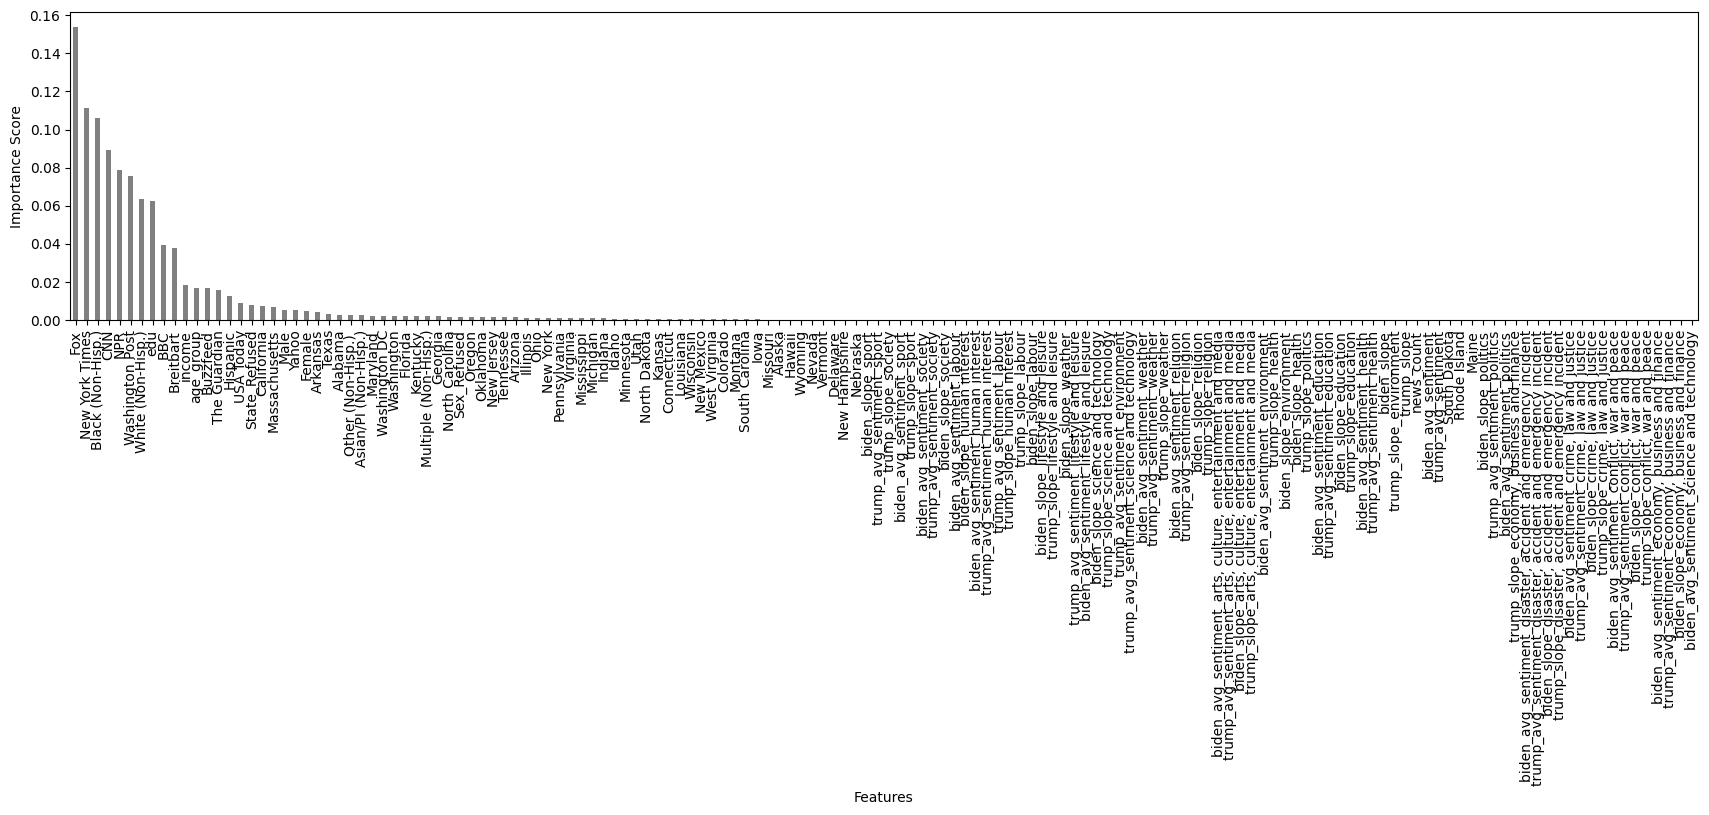

In [9]:
# plot feature importance
feature_importance = pd.Series(rf_best.feature_importances_, index=final_X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(21, 4), color='gray')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [10]:
y_val_pred = rf_best.predict(final_X_val)
val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_report_df = pd.DataFrame(val_report).T
val_report_df

,precision,recall,f1-score,support
1,0.775839,0.778976,0.777404,742.00000
2,0.705036,0.701252,0.703139,559.00000
accuracy,0.745580,0.745580,0.745580,0.74558
macro avg,0.740437,0.740114,0.740272,1301.00000
weighted avg,0.745417,0.745580,0.745495,1301.00000


In [11]:
# Save model
joblib.dump(rf_best, 'models/pretrained_news_content_model.pkl')

['models/pretrained_news_content_model.pkl']

In [12]:
# Prepare test features using the best time window and same attributes
final_X_test = calculate_features_with_window(
    X_test, news_df, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources
)
final_X_test = final_X_test[final_X_train.columns]  # Ensure column order matches training

# 3. Predict and evaluate
y_test_pred = rf_best.predict(final_X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
test_report_df = pd.DataFrame(test_report).T
test_report_df

Test Accuracy: 0.7378939277478862


,precision,recall,f1-score,support
1,0.756579,0.786594,0.771294,731.000000
2,0.711645,0.675439,0.693069,570.000000
accuracy,0.737894,0.737894,0.737894,0.737894
macro avg,0.734112,0.731016,0.732182,1301.000000
weighted avg,0.736892,0.737894,0.737022,1301.000000


In [13]:
# Calculate 95% confidence interval for the test accuracy
n = len(y_test)
z = norm.ppf(0.975)  # 1.96 for 95% confidence
se = np.sqrt((test_accuracy * (1 - test_accuracy)) / n)
margin_of_error = z * se

print(f"Test Accuracy: {test_accuracy:.3f} ± {margin_of_error:.3f} (95% CI)")
print(f"95% CI: [{test_accuracy - margin_of_error:.3f}, {test_accuracy + margin_of_error:.3f}]")

Test Accuracy: 0.738 ± 0.024 (95% CI)
95% CI: [0.714, 0.762]
